In [1]:
%matplotlib inline

# 이번에는 CIFAR10을 학습해봅시다

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# transform

## PIL 이미지는 [0~1] 이므로 image mean 값으로 바꾸고 싶어요!

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170156032/170498071 [03:42<00:00, 2098476.34it/s]

Files already downloaded and verified


# Trainset을 봐봅시다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck truck   dog  ship


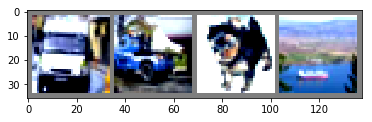

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 방금 MNIST와 같은 네트워크지만, 입력이 3 channel RGB, 입력 layer만 다릅니다.

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# loss function (손실함수)와 optimizer 를 정의

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 네트워크를 학습합시다!

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

170500096it [04:00, 2098476.34it/s]                               

[1,  2000] loss: 2.057
[1,  4000] loss: 1.734
[1,  6000] loss: 1.629
[1,  8000] loss: 1.553
[1, 10000] loss: 1.491
[1, 12000] loss: 1.442
[2,  2000] loss: 1.374
[2,  4000] loss: 1.352
[2,  6000] loss: 1.332
[2,  8000] loss: 1.340
[2, 10000] loss: 1.308
[2, 12000] loss: 1.309
Finished Training


# trainset의 크기는 12000, 그리고 저희는 epoch 2번,

## 즉 데이터셋을 총 2번 학습시켰습니다.

## 이제 테스트셋을 봅시다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


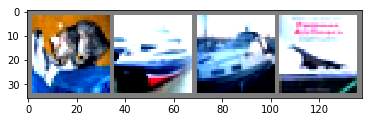

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 네트워크는 뭐라고 생각할까요?

In [9]:
outputs = net(images)

## 네트워크는 10 dim vector을 출력하므로, 우리가 알아보기 쉽게 최대값을 봅시다.

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


## 꽤 잘했네요! 실제 성능은 얼마나 될까요?

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


 89%|████████▉ | 2234/2500 [00:15<00:01, 150.71it/s]


100%|██████████| 2500/2500 [00:17<00:00, 144.08it/s]

Accuracy of the network on the 10000 test images: 53 %


## 찍는 거보단 잘했네요. (10%)

## 어떤 class를 잘 학습했는지 볼까요.

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 44 %
Accuracy of   car : 79 %
Accuracy of  bird : 55 %
Accuracy of   cat : 45 %
Accuracy of  deer : 42 %
Accuracy of   dog : 25 %
Accuracy of  frog : 64 %
Accuracy of horse : 63 %
Accuracy of  ship : 67 %
Accuracy of truck : 50 %


## 더 학습해볼까요?

In [13]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.242
[1,  4000] loss: 1.231
[1,  6000] loss: 1.221
[1,  8000] loss: 1.190
[1, 10000] loss: 1.227
[1, 12000] loss: 1.216
Finished Training


## 성능은?!

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


# 내 모델 저장하기

In [15]:
torch.save(net.state_dict(), 'my_cifar.pth') 

# 내 모델 다시 불러오기 :
## 지금 jupyter session을 초기화 합시다. Esc 누르고 숫자 0 두번 연타, 하고 restart 클릭

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
checkpoint = torch.load('./my_cifar.pth', map_location=lambda storage, loc: storage)

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


net.load_state_dict(checkpoint)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


# 아까 성능 그대로 나와야겠죠?

In [5]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


# 이어서 학습하기

## 유의점. net.train() 으로 train모드로 바꿔주기
##  BatchNorm, Dropout 등의 특정 layer는 model.train() 과 model.eval() 모드에 따라 연산이 다름

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

net.train()

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Files already downloaded and verified
[1,  2000] loss: 1.123
[1,  4000] loss: 1.143
[1,  6000] loss: 1.183
[1,  8000] loss: 1.137
[1, 10000] loss: 1.148
[1, 12000] loss: 1.145
Finished Training


# 이어서 학습한 모델, 테스트해보기

In [7]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


# Pretrained 모델을 받아봅시다.

저는 구글링해보니 https://github.com/akamaster/pytorch_resnet_cifar10 에서 pretrained모델을 제공한다길래 받아봅니다.
우선 홈폴더에 ``git clone https://github.com/akamaster/pytorch_resnet_cifar10``

그리고 `resnet.py` 파일과 `pretrained_models`를 지금 경로로 옮겨옵니다.

# 유의할점.
- 1. 같은 preprocess 를 거치는가? Image Normalization 등.
- 2. model.eval() 할 것. BatchNorm, Dropout 등의 특정 layer는 model.train() 과 model.eval() 모드에 따라 연산이 다름

In [8]:
import resnet
resnet20 = torch.nn.DataParallel(resnet.resnet20())

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Linear
ResNet


/home/jonhpark/workspace/fastcampus_dl_gpu/day4/resnet.py:43: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [9]:
# resnet20 = torch.load('./resnet20.th') ## GPU 일때
checkpoint = torch.load('./pretrained_models/resnet20.th', map_location=lambda storage, loc: storage) ## CPU 일때
resnet20.load_state_dict(checkpoint['state_dict'])

# resnet20 pretrained 모델로 테스트를 돌려봅시다.

In [10]:
from tqdm import tqdm
resnet20.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader):
        # print(i)
        images, labels = data
        outputs = resnet20(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

100%|██████████| 2500/2500 [01:41<00:00, 24.60it/s]

Accuracy of the network on the 10000 test images: 91 %
